In [27]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_model_to_s3, load_model_from_s3
from sklearn.preprocessing import OneHotEncoder


In [ ]:
# Load box scores data from multiple seasons (same as Lambda)
df = load_dataframe_from_s3('data/box_scores/current.parquet')
df2 = load_dataframe_from_s3('data/box_scores/2024-2025.parquet')
df3 = load_dataframe_from_s3('data/box_scores/2023-2024.parquet')
df4 = load_dataframe_from_s3('data/box_scores/2022-2023.parquet')
df = pd.concat([df, df2, df3, df4])

print(f"Loaded {len(df)} box score records from multiple seasons")

# Validate box scores data structure
required_box_score_cols = ['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'MIN', 'MATCHUP']
missing_cols = [col for col in required_box_score_cols if col not in df.columns]
if missing_cols:
    print(f"Missing required columns in box scores data: {missing_cols}")

# Filter out players with zero minutes (data validation)
if 'MIN' in df.columns:
    original_count = len(df)
    df = df[df['MIN'] != 0]
    print(f"Filtered from {original_count} to {len(df)} records (MIN != 0)")

# Sort by game date (most recent first) - same as Lambda
df = df.sort_values(by=['GAME_DATE'], ascending=[False])

print(f"First few rows after filtering:")
print(df.head())

In [32]:
# clusterDict = {}
df.describe()

,GAME_DATE,FG_PCT,FG3_PCT,FT_PCT,FP,CLUSTER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,78307,74400.000000,61816.000000,43228.000000,78307.000000,61117.000000,78307.000000,78307.000000,78307.000000,78307.000000
mean,2024-01-18 03:31:57.207912448,0.462133,0.335594,0.767472,21.704822,7.113078,21.586274,21.505656,21.443834,20.921622
min,2022-10-18 00:00:00,0.000000,0.000000,0.000000,-3.500000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,2023-02-28 00:00:00,0.333000,0.000000,0.500000,9.900000,3.000000,11.500000,11.800000,11.857143,11.950000
50%,2024-01-20 00:00:00,0.474000,0.333000,0.857000,19.700000,7.000000,19.900000,19.840000,19.757143,19.225000
75%,2024-12-02 00:00:00,0.600000,0.500000,1.000000,31.300000,10.000000,30.000000,29.700000,29.485714,28.283333
max,2025-04-13 00:00:00,1.000000,1.000000,1.000000,105.200000,14.000000,89.266667,80.740000,75.671429,72.200000
std,NaN,0.239236,0.288643,0.281915,14.986318,3.894061,13.093938,12.654407,12.454016,11.867607


In [34]:
print("Data type:", df['MIN'].dtype)
df['MIN'] = pd.to_numeric(df['MIN'], errors='coerce')
print("Data type:", df['MIN'].dtype)
print(df['MIN'].head(10))
df['MIN'] = df['MIN'] + np.random.uniform(-5, 5, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)
df['MIN']

Data type: object
Data type: int64
16894    35
6995     25
12243    12
6823     36
2897     38
22896    43
12170    17
21301    29
6893     24
680      15
Name: MIN, dtype: int64


16894    39.770706
6995     25.113089
12243     8.902281
6823     40.253267
2897     37.951982
           ...    
23790    34.070942
15228    24.187055
4002      3.568770
21713    35.243440
12307    36.468689
Name: MIN, Length: 78307, dtype: float64

In [ ]:
# Data preprocessing for MIN column (convert to numeric and add noise - same as Lambda)
print("Original MIN dtype:", df['MIN'].dtype)
df['MIN'] = pd.to_numeric(df['MIN'], errors='coerce')
print("After to_numeric:", df['MIN'].dtype)
print("Sample MIN values before noise:", df['MIN'].head(10).tolist())

# Add random noise to MIN (prevents overfitting to exact minute values)
df['MIN'] = df['MIN'] + np.random.uniform(-5, 5, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)

print("Sample MIN values after noise:", df['MIN'].head(10).tolist())

In [ ]:
# Replace NaN with a placeholder before encoding
df['CLUSTER'] = df['CLUSTER'].fillna('CLUSTER_NAN')

# Parse MATCHUP to extract home/away and opponent
def parse_matchup(matchup_str):
    if pd.isna(matchup_str):
        return 0, 'UNKNOWN'
    matchup_str = str(matchup_str)
    if ' @ ' in matchup_str:
        # Away game: "TOR @ NYK"
        teams = matchup_str.split(' @ ')
        return 0, teams[1] if len(teams) > 1 else 'UNKNOWN'
    elif ' vs. ' in matchup_str:
        # Home game: "TOR vs. PHX" 
        teams = matchup_str.split(' vs. ')
        return 1, teams[1] if len(teams) > 1 else 'UNKNOWN'
    else:
        return 0, 'UNKNOWN'

# Apply parsing
matchup_parsed = df['MATCHUP'].apply(parse_matchup)
df['IS_HOME'] = matchup_parsed.apply(lambda x: x[0])
df['OPPONENT'] = matchup_parsed.apply(lambda x: x[1])

print(f"Parsed MATCHUP: {(df['IS_HOME'] == 1).sum()} home games, {(df['IS_HOME'] == 0).sum()} away games")

# Calculate rest days first
from datetime import datetime, timezone, timedelta
import pytz

def calculate_rest_days(df):
    """Calculate rest days for each player based on their previous game"""
    # Create a copy to avoid modifying the original
    df_sorted = df.copy()
    
    # Ensure GAME_DATE is datetime
    df_sorted['GAME_DATE'] = pd.to_datetime(df_sorted['GAME_DATE'])
    
    # Sort by player and game date (ascending for proper calculation)
    df_sorted = df_sorted.sort_values(['PLAYER', 'GAME_DATE'])
    
    # Calculate days since last game for each player
    df_sorted['PREV_GAME_DATE'] = df_sorted.groupby('PLAYER')['GAME_DATE'].shift(1)
    df_sorted['REST_DAYS'] = (df_sorted['GAME_DATE'] - df_sorted['PREV_GAME_DATE']).dt.days
    
    # For first games (no previous game), set rest days to 3 (reasonable default)
    df_sorted['REST_DAYS'] = df_sorted['REST_DAYS'].fillna(3).astype(int)
    
    # For predictions (current games), calculate rest days from most recent game to today
    # Get current date in ET timezone
    et_tz = pytz.timezone('America/New_York')
    today = datetime.now(et_tz).date()
    
    # Get most recent game for each player
    most_recent_games = df_sorted.groupby('PLAYER')['GAME_DATE'].max().reset_index()
    most_recent_games['MOST_RECENT_DATE'] = most_recent_games['GAME_DATE']
    
    # Merge back and update REST_DAYS for prediction cases
    df_sorted = df_sorted.merge(most_recent_games[['PLAYER', 'MOST_RECENT_DATE']], on='PLAYER', how='left')
    
    # Calculate rest days from most recent game to today for predictions
    current_rest_days = (pd.Timestamp(today) - df_sorted['MOST_RECENT_DATE']).dt.days
    
    # For the most recent games, use the calculated rest days from today
    is_most_recent = df_sorted['GAME_DATE'] == df_sorted['MOST_RECENT_DATE']
    df_sorted.loc[is_most_recent, 'REST_DAYS'] = current_rest_days[is_most_recent]
    
    # Clean up temporary columns
    df_sorted = df_sorted.drop(columns=['PREV_GAME_DATE', 'MOST_RECENT_DATE'])
    
    # Ensure REST_DAYS is non-negative and reasonable (cap at 30 days for outliers)
    df_sorted['REST_DAYS'] = df_sorted['REST_DAYS'].clip(0, 30)
    
    print(f"Rest days calculated: min={df_sorted['REST_DAYS'].min()}, max={df_sorted['REST_DAYS'].max()}, mean={df_sorted['REST_DAYS'].mean():.2f}")
    
    return df_sorted

# Calculate rest days
df = calculate_rest_days(df)

# Calculate career-based features across all loaded seasons
print("Calculating career averages from multi-year data")

# Sort by player and date to ensure proper temporal ordering
df = df.sort_values(['PLAYER', 'GAME_DATE'])

# Calculate career average FP (all historical data across all seasons)
# Uses shift(1) to avoid data leakage - only knows about games BEFORE current game
df['Career_FP_Avg'] = df.groupby('PLAYER')['FP'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).mean()
)

# Track cumulative games played for each player (useful context for model)
df['Games_Played_Career'] = df.groupby('PLAYER').cumcount()

print(f"Career features calculated - Career_FP_Avg mean: {df['Career_FP_Avg'].mean():.2f}, "
       f"Max games played: {df['Games_Played_Career'].max()}")

# Handle NaN values in rolling averages (from first games of season)
print("Handling NaN values in rolling averages")

# Fill missing rolling averages with season average as fallback
df['Last3_FP_Avg'] = df['Last3_FP_Avg'].fillna(df['Season_FP_Avg'])
df['Last7_FP_Avg'] = df['Last7_FP_Avg'].fillna(df['Season_FP_Avg'])

# For first games with no season average, use 0 (model will learn this represents unknown)
df['Last3_FP_Avg'] = df['Last3_FP_Avg'].fillna(0)
df['Last7_FP_Avg'] = df['Last7_FP_Avg'].fillna(0)
df['Season_FP_Avg'] = df['Season_FP_Avg'].fillna(0)

# For first career game, Career_FP_Avg will be NaN - fill with 0
df['Career_FP_Avg'] = df['Career_FP_Avg'].fillna(0)

print(f"After NaN handling - Last3_FP_Avg nulls: {df['Last3_FP_Avg'].isna().sum()}")
print(f"After NaN handling - Season_FP_Avg nulls: {df['Season_FP_Avg'].isna().sum()}")
print(f"After NaN handling - Career_FP_Avg nulls: {df['Career_FP_Avg'].isna().sum()}")

# Keep relevant columns including career features
df = df[['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last7_FP_Avg', 
         'Season_FP_Avg', 'Career_FP_Avg', 'Games_Played_Career', 'CLUSTER', 'MIN', 
         'IS_HOME', 'OPPONENT', 'REST_DAYS']]
players = df['PLAYER']
gameDates = df['GAME_DATE']

# Now create features with career features included
featureNames = ['Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg',
                'Career_FP_Avg', 'Games_Played_Career', 'CLUSTER', 'MIN',
                'IS_HOME', 'OPPONENT', 'REST_DAYS']
labelName = ['FP']
dfFeatures = df[featureNames]
dfLabels = df[labelName]

# One-hot encode categorical features
dfFeatures = pd.get_dummies(dfFeatures, columns=['CLUSTER', 'OPPONENT'], drop_first=False)
print(f"Ready for training with {len(df)} records")

In [36]:
labels = np.array(dfLabels).ravel()  # Fix: flatten to 1D array to avoid sklearn warning
features = np.array(dfFeatures)
df.head()

,SEASON_ID,PLAYER_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER TEAM,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,...,VIDEO_AVAILABLE,PLAYER,CLUSTER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,IS_HOME,OPPONENT,REST_DAYS
0,22022,1630639,1610612750,MIN,Minnesota Timberwolves,0022200212,2022-11-16,MIN @ ORL,W,0.000000,...,1,a.j. lawson,13.0,3.200000,3.200000,3.200000,3.200000,0,ORL,3
1,22022,1630639,1610612742,DAL,Dallas Mavericks,0022200528,2022-12-29,DAL vs. HOU,W,0.000000,...,1,a.j. lawson,13.0,1.600000,1.600000,1.600000,1.600000,1,HOU,30
2,22022,1630639,1610612742,DAL,Dallas Mavericks,0022200577,2023-01-05,DAL vs. BOS,L,6.832124,...,1,a.j. lawson,13.0,1.066667,1.066667,1.066667,1.066667,1,BOS,6
3,22022,1630639,1610612742,DAL,Dallas Mavericks,0022200593,2023-01-07,DAL vs. NOP,W,0.000000,...,1,a.j. lawson,13.0,0.000000,0.800000,0.800000,0.800000,1,NOP,1
4,22022,1630639,1610612742,DAL,Dallas Mavericks,0022200602,2023-01-08,DAL @ OKC,L,6.320320,...,1,a.j. lawson,13.0,0.000000,0.640000,0.640000,0.640000,0,OKC,0


In [38]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.25, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [ ]:
# TEST A: Baseline with CLUSTER (current setup without Last5)
print("=" * 60)
print("TEST A: WITH CLUSTER Features (Baseline)")
print("=" * 60)

# Updated to match Lambda - no Last5
featureNames_baseline = ['Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg',
                         'Career_FP_Avg', 'Games_Played_Career', 'CLUSTER', 'MIN',
                         'IS_HOME', 'OPPONENT', 'REST_DAYS']
dfFeatures_baseline = df[featureNames_baseline]
dfFeatures_baseline = pd.get_dummies(dfFeatures_baseline, columns=['CLUSTER', 'OPPONENT'], drop_first=False)
print(f"Feature count with CLUSTER: {len(dfFeatures_baseline.columns)}")

labels_baseline = np.array(dfLabels).ravel()
features_baseline = np.array(dfFeatures_baseline)

train_A, test_A, trainLabels_A, testLabels_A, trainPlayers_A, testPlayers_A, trainDates_A, testDates_A = train_test_split(
    features_baseline, labels_baseline, players, gameDates, test_size=0.25, random_state=30
)

rf_A = RandomForestRegressor(random_state=4)
rf_A.fit(train_A, trainLabels_A)

train_predictions_A = rf_A.predict(train_A)
test_predictions_A = rf_A.predict(test_A)

train_error_A = np.mean(abs(train_predictions_A - trainLabels_A))
test_error_A = np.mean(abs(test_predictions_A - testLabels_A))

# Feature importance
feature_importance_A = dict(zip(dfFeatures_baseline.columns, rf_A.feature_importances_))
all_features_sorted_A = sorted(feature_importance_A.items(), key=lambda x: x[1], reverse=True)
top_features_A = all_features_sorted_A[:10]

print(f"\nTrain MAE: {train_error_A:.4f}")
print(f"Test MAE: {test_error_A:.4f}")
print(f"\nTop 10 Features:")
for feat, imp in top_features_A:
    print(f"  {feat}: {imp:.6f}")

# Calculate total CLUSTER importance
cluster_features = [f for f, _ in all_features_sorted_A if f.startswith('CLUSTER_')]
total_cluster_imp = sum([imp for f, imp in all_features_sorted_A if f.startswith('CLUSTER_')])
print(f"\nTotal CLUSTER importance: {total_cluster_imp:.6f} ({total_cluster_imp*100:.2f}%)")
print(f"Number of CLUSTER features: {len(cluster_features)}")

# ============================================================================
# TEST B: Without CLUSTER
print("\n" + "=" * 60)
print("TEST B: WITHOUT CLUSTER Features (Removed)")
print("=" * 60)

# Create features WITHOUT CLUSTER
featureNames_no_cluster = ['Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg',
                            'Career_FP_Avg', 'Games_Played_Career', 'MIN',
                            'IS_HOME', 'OPPONENT', 'REST_DAYS']
dfFeatures_no_cluster = df[featureNames_no_cluster]
dfFeatures_no_cluster = pd.get_dummies(dfFeatures_no_cluster, columns=['OPPONENT'], drop_first=False)
print(f"Feature count without CLUSTER: {len(dfFeatures_no_cluster.columns)}")

labels_no_cluster = np.array(dfLabels).ravel()
features_no_cluster = np.array(dfFeatures_no_cluster)

train_B, test_B, trainLabels_B, testLabels_B, trainPlayers_B, testPlayers_B, trainDates_B, testDates_B = train_test_split(
    features_no_cluster, labels_no_cluster, players, gameDates, test_size=0.25, random_state=30
)

rf_B = RandomForestRegressor(random_state=4)
rf_B.fit(train_B, trainLabels_B)

train_predictions_B = rf_B.predict(train_B)
test_predictions_B = rf_B.predict(test_B)

train_error_B = np.mean(abs(train_predictions_B - trainLabels_B))
test_error_B = np.mean(abs(test_predictions_B - testLabels_B))

# Feature importance
feature_importance_B = dict(zip(dfFeatures_no_cluster.columns, rf_B.feature_importances_))
all_features_sorted_B = sorted(feature_importance_B.items(), key=lambda x: x[1], reverse=True)
top_features_B = all_features_sorted_B[:10]

print(f"\nTrain MAE: {train_error_B:.4f}")
print(f"Test MAE: {test_error_B:.4f}")
print(f"\nTop 10 Features:")
for feat, imp in top_features_B:
    print(f"  {feat}: {imp:.6f}")

# ============================================================================
# COMPARISON
print("\n" + "=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)
print(f"Test A (WITH CLUSTER):    Train MAE = {train_error_A:.4f}, Test MAE = {test_error_A:.4f}")
print(f"Test B (WITHOUT CLUSTER): Train MAE = {train_error_B:.4f}, Test MAE = {test_error_B:.4f}")
print(f"\nDifference in Test MAE: {test_error_A - test_error_B:.4f}")
if test_error_B < test_error_A:
    print(f"✅ Removing CLUSTER IMPROVED test error by {test_error_A - test_error_B:.4f}")
elif test_error_B > test_error_A:
    print(f"❌ Removing CLUSTER WORSENED test error by {test_error_B - test_error_A:.4f}")
else:
    print("➡️ No change in test error")

# Check how other features change
min_imp_A = feature_importance_A.get('MIN', 0)
season_imp_A = feature_importance_A.get('Season_FP_Avg', 0)
career_imp_A = feature_importance_A.get('Career_FP_Avg', 0)

min_imp_B = feature_importance_B.get('MIN', 0)
season_imp_B = feature_importance_B.get('Season_FP_Avg', 0)
career_imp_B = feature_importance_B.get('Career_FP_Avg', 0)

print(f"\nFeature importance shifts when CLUSTER removed:")
print(f"MIN:            {min_imp_A:.6f} → {min_imp_B:.6f} ({(min_imp_B-min_imp_A)*100:+.2f}%)")
print(f"Season_FP_Avg:  {season_imp_A:.6f} → {season_imp_B:.6f} ({(season_imp_B-season_imp_A)*100:+.2f}%)")
print(f"Career_FP_Avg:  {career_imp_A:.6f} → {career_imp_B:.6f} ({(career_imp_B-career_imp_A)*100:+.2f}%)")

In [ ]:
# Store results
comparison_results = []

# Add trend features function
def add_trend_features(df):
    """Add trend and volatility features"""
    # Ensure proper sorting
    df = df.sort_values(['PLAYER', 'GAME_DATE'])

    # 1. Performance trend (3-game direction)
    df['FP_trend_3game'] = df.groupby('PLAYER')['FP'].transform(
        lambda x: x.rolling(3).apply(
            lambda vals: (vals.iloc[-1] - vals.iloc[0]) if len(vals) == 3 else 0
        )
    )

    # 2. Performance volatility (5-game consistency)
    df['FP_volatility_5game'] = df.groupby('PLAYER')['FP'].transform(
        lambda x: x.rolling(5, min_periods=1).std()
    ).fillna(0)

    return df

# Define feature lists
featureNames_baseline = ['Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS']
featureNames_with_trends = ['Last3_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN', 'IS_HOME', 'OPPONENT', 'REST_DAYS', 'FP_trend_3game', 'FP_volatility_5game']

print("Feature comparison setup:")
print(f"Baseline features: {len(featureNames_baseline)}")
print(f"Enhanced features: {len(featureNames_with_trends)}")

# Store results
comparison_results = []

# Separate current season data (2024-25)
current_season_mask = df['GAME_DATE'] >= '2024-10-01'
df_current = df[current_season_mask].copy().reset_index(drop=True)

# Separate OLDER historical data (2022-2024, excluding current season)
df_historical_only = df[~current_season_mask].copy().reset_index(drop=True)

print("Preparing data...")
print(f"Current season data: {len(df_current)} games")
print(f"Historical data: {len(df_historical_only)} games")

for i in range(20):
    print(f"\n=== ITERATION {i+1}/20 ===")

    random_seed = i + 42

    # Simple approach: split current season data directly
    train_current_df, test_current_df = train_test_split(
        df_current, test_size=0.25, random_state=random_seed
    )

    # CRITICAL FIX: Add trend features ONLY to training data
    # This prevents data leakage from test set
    train_df = pd.concat([
        df_historical_only,  # All older games
        train_current_df     # Only current season TRAINING games (not test!)
    ], ignore_index=True)

    # Add trend features to TRAINING data only
    train_df_with_trends = add_trend_features(train_df)

    # Add trend features to TEST data separately (no leakage)
    test_df_with_trends = add_trend_features(test_current_df)

    # Baseline model (original features)
    baseline_train_features = train_df_with_trends[featureNames_baseline].copy()
    baseline_train_features = pd.get_dummies(baseline_train_features, columns=['CLUSTER', 'OPPONENT'])
    baseline_train_labels = train_df_with_trends['FP'].values

    # Enhanced model (with trend features)
    enhanced_train_features = train_df_with_trends[featureNames_with_trends].copy()
    enhanced_train_features = pd.get_dummies(enhanced_train_features, columns=['CLUSTER', 'OPPONENT'])
    enhanced_train_labels = train_df_with_trends['FP'].values

    # Test features (same test set for both models) - calculated separately
    test_baseline_features = test_df_with_trends[featureNames_baseline].copy()
    test_baseline_features = pd.get_dummies(test_baseline_features, columns=['CLUSTER', 'OPPONENT'])
    test_current_labels = test_df_with_trends['FP'].values

    test_enhanced_features = test_df_with_trends[featureNames_with_trends].copy()
    test_enhanced_features = pd.get_dummies(test_enhanced_features, columns=['CLUSTER', 'OPPONENT'])

    # Ensure both feature sets have same columns (for one-hot encoding consistency)
    # For baseline model
    all_columns_baseline = set(baseline_train_features.columns) | set(test_baseline_features.columns)

    for col in all_columns_baseline:
        if col not in baseline_train_features.columns:
            baseline_train_features[col] = 0
        if col not in test_baseline_features.columns:
            test_baseline_features[col] = 0

    baseline_train_features = baseline_train_features[sorted(all_columns_baseline)]
    test_baseline_features = test_baseline_features[sorted(all_columns_baseline)]

    # For enhanced model
    all_columns_enhanced = set(enhanced_train_features.columns) | set(test_enhanced_features.columns)

    for col in all_columns_enhanced:
        if col not in enhanced_train_features.columns:
            enhanced_train_features[col] = 0
        if col not in test_enhanced_features.columns:
            test_enhanced_features[col] = 0

    enhanced_train_features = enhanced_train_features[sorted(all_columns_enhanced)]
    test_enhanced_features = test_enhanced_features[sorted(all_columns_enhanced)]

    # Train both models
    print("Training baseline model...")
    rf_baseline = RandomForestRegressor(n_estimators=50, random_state=random_seed, n_jobs=-1)
    rf_baseline.fit(baseline_train_features, baseline_train_labels)

    print("Training enhanced model...")
    rf_enhanced = RandomForestRegressor(n_estimators=50, random_state=random_seed, n_jobs=-1)
    rf_enhanced.fit(enhanced_train_features, enhanced_train_labels)

    # Test both on same current season test set
    baseline_pred = rf_baseline.predict(test_baseline_features)
    enhanced_pred = rf_enhanced.predict(test_enhanced_features)

    baseline_error = np.mean(np.abs(baseline_pred - test_current_labels))
    enhanced_error = np.mean(np.abs(enhanced_pred - test_current_labels))

    comparison_results.append({
        'iteration': i+1,
        'baseline_mae': baseline_error,
        'enhanced_mae': enhanced_error,
        'test_improvement': baseline_error - enhanced_error  # Positive = trends helped
    })

    print(f"Baseline Model MAE: {baseline_error:.3f}")
    print(f"Enhanced Model MAE: {enhanced_error:.3f}")
    print(f"Improvement from Trends: {baseline_error - enhanced_error:.3f}")

# Analysis and plotting code
results_df = pd.DataFrame(comparison_results)
print(f"\n=== FINAL RESULTS AFTER 20 ITERATIONS ===")
print(f"Baseline Model Avg MAE: {results_df['baseline_mae'].mean():.3f} ± {results_df['baseline_mae'].std():.3f}")
print(f"Enhanced Model Avg MAE: {results_df['enhanced_mae'].mean():.3f} ± {results_df['enhanced_mae'].std():.3f}")
print(f"Avg Improvement from Trends: {results_df['test_improvement'].mean():.3f} ± {results_df['test_improvement'].std():.3f}")
print(f"Times trends helped: {(results_df['test_improvement'] > 0).sum()}/20")

# Show percentage improvement
avg_improvement_pct = (results_df['test_improvement'].mean() / results_df['baseline_mae'].mean()) * 100
print(f"Average improvement percentage: {avg_improvement_pct:.2f}%")

Feature comparison setup:
Baseline features: 9
Enhanced features: 11
Preparing data...
Current season data: 26206 games
Historical data: 52101 games

=== ITERATION 1/20 ===
Training baseline model...
Training enhanced model...
Baseline Model MAE: 5.210
Enhanced Model MAE: 4.403
Improvement from Trends: 0.807

=== ITERATION 2/20 ===
Training baseline model...
Training enhanced model...
Baseline Model MAE: 5.248
Enhanced Model MAE: 4.457
Improvement from Trends: 0.791

=== ITERATION 3/20 ===
Training baseline model...
Training enhanced model...
Baseline Model MAE: 5.176
Enhanced Model MAE: 4.421
Improvement from Trends: 0.755

=== ITERATION 4/20 ===
Training baseline model...
Training enhanced model...
Baseline Model MAE: 5.185
Enhanced Model MAE: 4.343
Improvement from Trends: 0.843

=== ITERATION 5/20 ===
Training baseline model...
Training enhanced model...
Baseline Model MAE: 5.295
Enhanced Model MAE: 4.445
Improvement from Trends: 0.850

=== ITERATION 6/20 ===
Training baseline mode

KeyboardInterrupt: 

In [ ]:
import pickle

# New model
# rf = RandomForestRegressor(random_state=4)
# rf.fit(train, trainLabels.ravel())
# save_model_to_s3(rf, "models/RFCluster_many_years.sav")

# Load the pre-trained model from AWS instead of training locally
print("Loading pre-trained RandomForest model from AWS...")
rf = load_model_from_s3("models/RFCluster.sav")

print("Model loaded successfully!")

Loading pre-trained RandomForest model from AWS...
Model loaded successfully!


In [ ]:
train_predictions = rf.predict(train)
predictions = rf.predict(test)


In [ ]:
# Create a mapping from one-hot encoded columns back to cluster numbers
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
reverse_cluster_map = {i: col.split('_')[-1] for i, col in enumerate(cluster_columns, start=1)}

In [ ]:
# Create a mapping from one-hot encoded columns back to cluster and opponent values
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
opponent_columns = [col for col in dfFeatures.columns if col.startswith('OPPONENT_')]

feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)

# Map back to original cluster and opponent values
df['CLUSTER'] = df[cluster_columns].idxmax(axis=1) if cluster_columns else 'UNKNOWN'
df['OPPONENT'] = df[opponent_columns].idxmax(axis=1) if opponent_columns else 'UNKNOWN'

# Map back to original cluster numbers safely
def safe_cluster_map(value):
    if isinstance(value, str) and value.startswith('CLUSTER_'):
        try:
            cluster_value = value.split('_')[-1]
            return float(cluster_value) if cluster_value != 'NAN' else np.nan
        except ValueError:
            return np.nan
    return np.nan

def safe_opponent_map(value):
    if isinstance(value, str) and value.startswith('OPPONENT_'):
        return value.split('_', 1)[-1]  # Get everything after first underscore
    return 'UNKNOWN'

df['CLUSTER'] = df['CLUSTER'].map(safe_cluster_map)
df['OPPONENT'] = df['OPPONENT'].map(safe_opponent_map)

# Drop the one-hot encoded columns if no longer needed
df = df.drop(columns=cluster_columns + opponent_columns)
df['PLAYER'] = testPlayers
df['GAME_DATE'] = testDates
df['ACTUAL'] = testLabels
df['PREDICTED'] = predictions
df['ERROR'] = abs(df['ACTUAL'] - df['PREDICTED'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [ ]:
# Old DF
# df.describe()

In [ ]:
df.describe()

,CLUSTER,GAME_DATE,ACTUAL,PREDICTED,ERROR
count,15323.000000,19577,19577.000000,19577.000000,19577.000000
mean,7.120277,2024-01-18 21:44:48.277059840,21.743582,21.942507,5.058982
min,0.000000,2022-10-18 00:00:00,-2.800000,-1.199000,0.000000
25%,3.000000,2023-03-01 00:00:00,9.900000,12.055000,1.729000
50%,7.000000,2024-01-19 00:00:00,19.800000,20.517000,3.968000
75%,10.000000,2024-12-03 00:00:00,31.500000,30.475000,7.295000
max,14.000000,2025-04-13 00:00:00,105.200000,88.316000,34.094000
std,3.905048,NaN,15.018680,13.406724,4.299493


In [ ]:
df.head(5)

,PLAYER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,MIN,IS_HOME,REST_DAYS,CLUSTER,OPPONENT,GAME_DATE,ACTUAL,PREDICTED,ERROR
0,nick richards,14.833333,17.84,18.828571,19.715385,23.761114,0,3,4.0,CHI,2023-12-06,26.2,18.450,7.750
1,josh hart,29.266667,25.44,24.3,28.132258,33.888654,0,1,5.0,DEN,2022-12-23,36.2,33.882,2.318
2,jrue holiday,33.0,33.86,31.228571,37.925,36.520457,0,2,9.0,NYK,2022-11-30,47.7,34.347,13.353
3,dillon brooks,17.066667,17.6,19.571429,21.9325,33.883998,1,1,3.0,CLE,2025-01-22,8.5,23.161,14.661
4,jayson tatum,44.833333,48.68,46.057143,46.276471,39.161521,1,1,8.0,ATL,2023-11-26,50.8,46.064,4.736


In [ ]:
save_dataframe_to_s3(df, 'data/test_player_predictions/current.parquet')

Saved 19577 records to s3://nba-prediction-ibracken/data/test_player_predictions/current.parquet


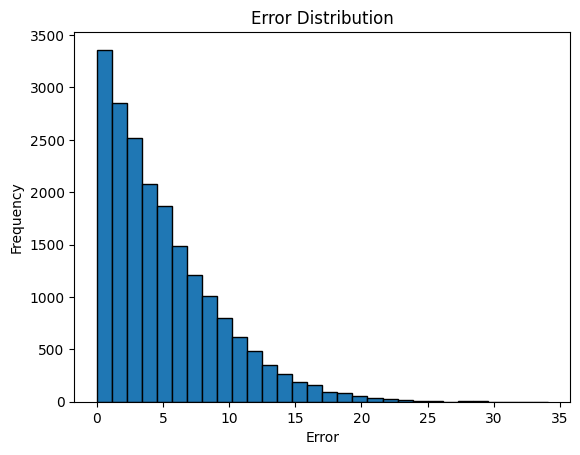

: 

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['ERROR'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()